In [1]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation
from models import *
from functools import partial
from jitcdde import jitcdde, y, t, jitcdde_input
import ipywidgets as widgets
from symengine import symbols

In [3]:
class delayed_oscillation(oscillation):
    def __init__(self, model, delay, params, consts, init_cond, calc_all):
        super().__init__(model, params, consts, init_cond, calc_all)
        self.__delay = delay
        self.dde = self._oscillation__model(self.__delay)

    @property
    def info(self):
        print(
            f'Time-delayed model. The model includes {len(self._oscillation__params)} parameters and {len(self._oscillation__consts)} constants. \
            The species are {self._oscillation__species}. Initial condition: {self._oscillation__init_cond}')
        print(f'Additional information: {self._oscillation__info}')

    def set_delay(self, delay):
        self.__delay = delay
        self.dde = self._oscillation__model(self.__delay)

    def simulate(self, t=10, exp=False):
        params_pass = np.hstack(
            (self._oscillation__params, self._oscillation__consts))
        
        if exp == True:
            y0 = np.array([self._oscillation__exp_data.iloc[0, 1],
                  self._oscillation__exp_data.iloc[0, 3]])
            t_end = self._oscillation__exp_data.iloc[-1, 0]
            t_eval = np.linspace(0, t_end, int(30*t_end))
            self.dde.constant_past(y0)
        else:
            t_eval = np.linspace(0, t, int(30*t))
            self.dde.constant_past(self._oscillation__init_cond)

        self.dde.reset_integrator()
        self.dde.set_parameters(params_pass)
        self.dde.step_on_discontinuities()

        sol = np.array([self.dde.integrate(time) for time in t_eval])

        return (sol, t_eval)

    def plot(self, t=10, exp=False, ylim=None):
        i = 0
        color = ['purple', 'b', 'r', 'g']
        if exp == True:
            sol, t = self.simulate(exp=exp)
            c = self._oscillation__calc_all(
                sol, self._oscillation__consts, self._oscillation__params)
            fig, axes = plt.subplots(2, 1, figsize=(5, 5))
            for ax in axes:
                #Expereimental data
                ax.plot(
                    self._oscillation__exp_data.iloc[:, 2*i], self._oscillation__exp_data.iloc[:, 2*i+1],
                    label=f'exp-{self._oscillation__species[i]}', color=color[i])
                #Simulation
                ax.plot(t, c[i], label=self._oscillation__species[i],
                        linestyle='--', color=color[i])
                if ylim != None:
                    ax.set_ylim(0, ylim)
                ax.set_xlabel('Normalized Time')
                ax.set_ylabel('Normalized Concentration')
                ax.legend(loc="upper right")
                i += 1
                plt.tight_layout()
        else:
            sol, t = self.simulate(t, exp=exp)
            c = self._oscillation__calc_all(
                sol, self._oscillation__consts, self._oscillation__params)
            fig, axes = plt.subplots(2, 2, figsize=(7, 5))
            #Simulations only
            for ax, y in zip(axes.flatten(), c):
                ax.plot(
                    t, y, label=self._oscillation__species[i], color=color[i])
                if ylim != None:
                    ax.set_ylim(0, ylim)
                ax.set_xlabel('Normalized Time')
                ax.set_ylabel('Normalized Concentration')
                ax.legend(loc="upper right")
                i += 1
                plt.tight_layout()
        return fig, axes

    def interactive_plot(self, t=10, ran=5, step=0.05, exp=False, ylim=None):
        if len(self._oscillation__params) == 4:
            def plot_temp(alpha, beta, theta, phi):
                params = [alpha, beta, theta, phi]
                params_old = self._oscillation__params
                self.set_params(params)
                self.plot(t, exp=exp, ylim=ylim)
                self.set_params(params_old)
        elif len(self._oscillation__params) == 5:
            def plot_temp(alpha, beta, theta, phi, K):
                params = [alpha, beta, theta, phi, K]
                params_old = self._oscillation__params
                self.set_params(params)
                self.plot(t, exp=exp, ylim=ylim)
                self.set_params(params_old)

        params_list = ['alpha', 'beta', 'theta', 'phi', 'K']
        sliders = []

        for i in range(len(self._oscillation__params)):
            slider = widgets.FloatSlider(value=self._oscillation__params[i], min=max(
                0, self._oscillation__params[i]-ran), max=self._oscillation__params[i]+ran, step=step, description=params_list[i])
            sliders.append(slider)

        if len(self._oscillation__params) == 4:
            interactive_widget = widgets.interactive(
                plot_temp, alpha=sliders[0], beta=sliders[1], theta=sliders[2], phi=sliders[3])
        elif len(self._oscillation__params) == 5:
            interactive_widget = widgets.interactive(
                plot_temp, alpha=sliders[0], beta=sliders[1], theta=sliders[2], phi=sliders[3], K=sliders[4])

        display(interactive_widget)

In [4]:
def delayed_approx_model_FTC(delays):
    td1, td2 = delays
    alpha, beta, theta, phi, lam, m = symbols('alpha beta theta phi lam m')
    dcA2dt = 1 - alpha * y(0) * y(1, t-td2)**m - theta * y(0)
    dcSdt = alpha/lam * y(0) * y(1, t-td2)**m - beta * y(1, t-td1)**m + theta/lam * y(0) - phi * y(1)
    dde = jitcdde([dcA2dt, dcSdt], control_pars=[alpha, beta, theta, phi, lam, m])
    return dde


def calc_all_delayed_approx_model_FTC(sol, consts, *params):
    lam, m = consts
    cA2 = sol[:, 0]
    cS = sol[:, 1]
    cM = cS ** m
    cA = 2 * (1 - cA2) - lam * (cS + cM)
    cO = 1 / (2 * (1 - cA2) - lam * (cS + cM)) ** 2
    return np.array([cA2, cS + cM, cA, cO])

In [5]:
cA2_tol = 14.5
CMC_3a = 1.56
tau = 1.15
df_3a_fig3_NatChem = pd.read_csv('Data_sets/3a_fig3_osc_NatChem_MH.csv')
df_3a_fig3_NatChem['Timea2'] /= tau
df_3a_fig3_NatChem['Times3a'] /= tau
df_3a_fig3_NatChem['s3a'] /= CMC_3a

In [6]:
params = np.array([15, 35.2, 0.65, 18.6])
consts = np.array([0.11, 2])
delay = np.array([0.02, 0.045])
init_cond = [0.9, 0]
delayed_model_fig3 = delayed_oscillation(delayed_approx_model_FTC, delay=delay, params=params, consts=consts, init_cond=init_cond, calc_all=calc_all_delayed_approx_model_FTC)
delayed_model_fig3.add_exp_data(df_3a_fig3_NatChem)

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


Generating, compiling, and loading C code.
Using default integration parameters.


C:\Users\chem-sedm6967\AppData\Local\Temp\ipykernel_7808\2933479598.py:36: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


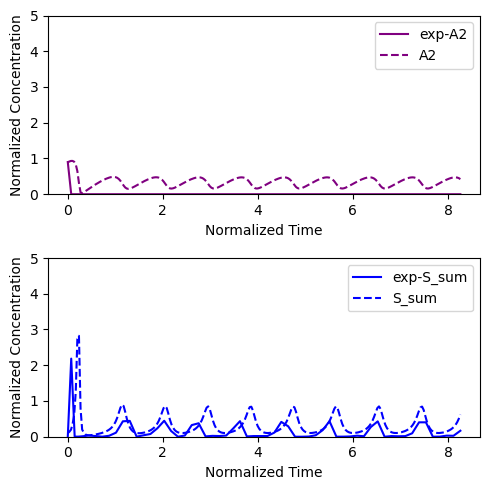

In [7]:
delayed_model_fig3.set_params(np.array([36, 51, 0.55, 20.4]))
fig, axes = delayed_model_fig3.plot(ylim=5, exp=True)

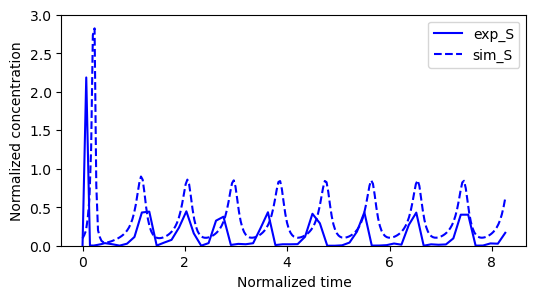

In [94]:
ax1 = axes[1]
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(ax1.lines[0].get_xdata(), ax1.lines[0].get_ydata(), label='exp_S', color='b')
ax.plot(ax1.lines[1].get_xdata(), ax1.lines[1].get_ydata(), label='sim_S', color='b', linestyle='--')
ax.set_xlabel('Normalized time')
ax.set_ylabel('Normalized concentration')
ax.set_ylim(0, 3)
ax.legend()

/var/folders/8j/x1ffcm515s74s8v0g59y641r0000gn/T/ipykernel_98429/2933479598.py:36: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


(-0.05, 2.0)

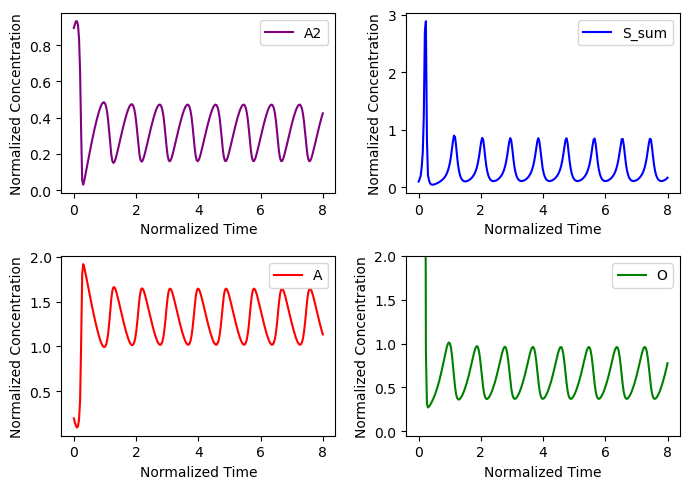

In [74]:
fig, ax = delayed_model_fig3.plot(t=8)
ax[1][1].set_ylim(-0.05, 2)

In [100]:
delayed_model_fig3.interactive_plot(exp=True, ran=30, ylim=2)

interactive(children=(FloatSlider(value=41.25, description='alpha', max=71.25, min=11.25, step=0.05), FloatSli…

/var/folders/8j/x1ffcm515s74s8v0g59y641r0000gn/T/ipykernel_98429/2933479598.py:36: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


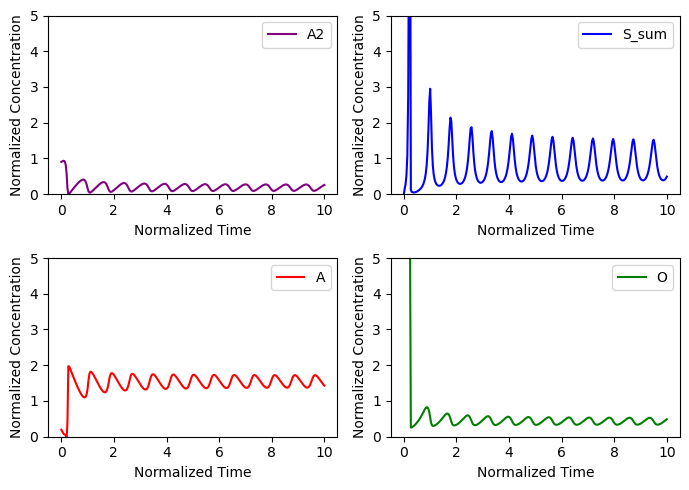

In [98]:
delayed_model_fig3.set_params(np.array([20, 15, 0.55, 10]))
fig, axes = delayed_model_fig3.plot(ylim=5)

In [26]:
files = ['Data_sets/1_expB_osc_NatChem_MH.csv',
         'Data_sets/3b_expB_osc_NatChem_MH.csv',
         'Data_sets/4_expB_osc_NatChem_MH.csv']

df_list = [pd.read_csv(file) for file in files]

exp_data = pd.concat(df_list, axis=1)

exp_data.columns = ['t1', 'c1', 't3b', 'c3b', 't4', 'c4']

cut_off, CMC_3b = 112, 0.52
tau = 0.25
C_A2tol = exp_data.loc[0, 'c1'] + exp_data.loc[0, 'c4'] / 2

exp_data = exp_data.head(cut_off)
exp_data[['c1', 'c4']] /= C_A2tol
exp_data['c3b'] /= CMC_3b

for s in ['t1', 't3b', 't4']:
    exp_data = exp_data.drop_duplicates(subset=s)
    exp_data[s] /= tau

df_fig1_MHNatChem = exp_data.clip(lower=0)
df_fig1_MHNatChem.loc[0, 't3b'] = 0
df_fig1_MHNatChem.loc[0, 't4'] = 0

The species are ['A2', 'S_sum', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).
Generating, compiling, and loading C code.


ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.


/var/folders/8j/x1ffcm515s74s8v0g59y641r0000gn/T/ipykernel_98429/2933479598.py:36: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


(<Figure size 700x500 with 4 Axes>,
 array([[<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
         <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>],
        [<Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>,
         <Axes: xlabel='Normalized Time', ylabel='Normalized Concentration'>]],
       dtype=object))

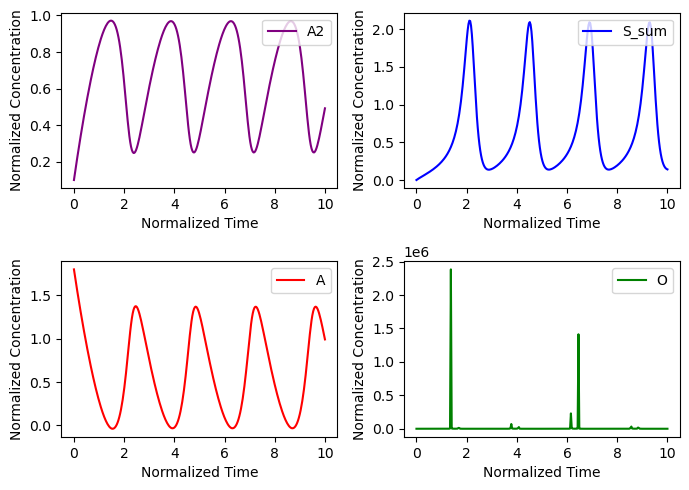

In [54]:
params = np.array([5.25, 0.2, 0.45, 13.7])
consts = np.array([0.17, 2])
init_cond = [0.1, 0]
delay = np.array([0.05, 0.1])
delayed_model = delayed_oscillation(delayed_approx_model_FTC, delay=delay, params=params, consts=consts, init_cond=init_cond, calc_all=calc_all_delayed_approx_model_FTC)
delayed_model.add_exp_data(df_fig1_MHNatChem)
delayed_model.plot()

In [ ]:
delayed_model.interactive_plot(exp=True, ran=50)

interactive(children=(FloatSlider(value=5.25, description='alpha', max=55.25, step=0.05), FloatSlider(value=0.…